In [2]:
#Modules import
import random
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
import queue

In [113]:
# Class of colors to use with the print funtion
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
#Class that represents a sample

class Sample:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the sample
        self.features = features #Array of feature values of the sample

In [3]:
#Class that represents a centroid

class Centroid:
    def __init__(self, identifier, features):
        self.identifier = identifier #Number that identifies the centroid
        self.features = features #Array of feature values of the centroid
        self.list_of_samples = [] #Array containing all the samples that are assigned to this centroid

In [4]:
#Function that applies the z-score method of normalization and standardization

def z_score_normalization(dataset, dimensions):
    for i in range(dimensions): #For each dimension i
        feature_values = [] #Create a list of all feature values of the i-th dimension
        for sample in dataset: #Fill the list
            feature_values.append(sample.features[i])
        feature_average = statistics.mean(feature_values) #Get the average value
        feature_stdev = statistics.stdev(feature_values) #Get the standard deviation value
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - feature_average)/(feature_stdev) 

In [4]:
#Function that applies the min-max method of normalization

def min_max_normalization(dataset, dimensions):
    for i in range(dimensions): #For each dimension i
        max_value = -math.inf #Maximum value between the feature values of the i-th dimension
        min_value = math.inf #Minimum value between the feature values of the i-th dimension
        for sample in dataset: #Calculate max_value and min_value
            if sample.features[i] > max_value:
                max_value = sample.features[i]
            if sample.features[i] < min_value:
                min_value = sample.features[i]
        for sample in dataset: #For each sample, adjust its feature value of the i-th dimension
            sample.features[i] = (sample.features[i] - min_value)/(max_value - min_value)

In [5]:
#Read the dataset from input file

def get_dataset(filename):

    dataset_file = open(filename,"r") #Get the input file
    dataset_file_lines = dataset_file.readlines() #Read all the lines of the input file
    dataset = [] #Array that will contain all samples objects
    
    for i in range(len(dataset_file_lines)): #For each line of the input file
        dataset_file_lines[i] = dataset_file_lines[i].split() #Split the line at the spaces
        features = list(map(float, dataset_file_lines[i])) #Get the features values list in float format
        new_sample = Sample(i+1, features) #Create new Sample object
        dataset.append(new_sample) #Append the new sample to the dataset
        
    return dataset

In [34]:
#Divide the dataset into training and test sets

def divide_dataset(dataset, training_set_proportion, test_set_proportion):

    training_set_size = math.floor(training_set_proportion*len(dataset)) #Get the size of the training set
#    test_set_size = math.ceil(test_set_proportion*len(dataset)) #Get the size of the test set
    test_set_size = len(dataset) - training_set_size
    training_set = [] #Traning set array
    test_set = [] #Test set array

    for i in range(len(dataset)): #Partition the dataset into traning and test sets
        if i < training_set_size:
            training_set.append(dataset[i])
        else:
            test_set.append(dataset[i])
    return training_set, test_set

In [7]:
#Function that calculates the euclidean distance between two samples

def get_distance(sample1, sample2, dimensions):
    sum = 0
    for i in range(dimensions):
        sum = sum + (sample1.features[i] - sample2.features[i])**2
    return math.sqrt(sum)

In [9]:
#Function that assings each sample to a centroid

def set_clusters(dataset, centroids, dimensions):
    
    for centroid in centroids: #Initialize the list of samples of each centroid as an empty list
        centroid.list_of_samples = []
        
    for sample in dataset: #For each sample
        closest_centroid = None #Variable that will contain the closest centroid
        min_distance = math.inf
        for centroid in centroids: #Check the distance of all centroids and select the closest
            distance = get_distance(sample, centroid, dimensions)
            if distance < min_distance:
                min_distance = distance
                closest_centroid = centroid
        closest_centroid.list_of_samples.append(sample) #Add the sample to the list of samples of the closest centroid

In [10]:
#Function that calculates the Sum of the Squared Error

def get_sse(centroids, dimensions):
    sum = 0
    for centroid in centroids:
        for sample in centroid.list_of_samples:
            sum = sum + get_distance(centroid, sample, dimensions)**2
    return sum

In [11]:
#Function that updates the features values of each centroid

def update_centroids(centroids):
    for centroid in centroids: #For each centroid
        for i in range(len(centroid.features)): #For each feature of the centroid
            centroid.features[i] = 0  
            for j in range(len(centroid.list_of_samples)): #Collected the feature value of each sample assigned to the centroid
                centroid.features[i] += centroid.list_of_samples[j].features[i]
            centroid.features[i] = centroid.features[i]/float(len(centroid.list_of_samples)) #Apply the average value

In [12]:
#Function that plots a 2D graph of the clusterization

def plot_2D_clusters(centroids):
    for centroid in centroids:
        x = []
        y = []
        for sample in centroid.list_of_samples:
            x.append(sample.features[0])
            y.append(sample.features[1])
        plt.scatter(x, y)    
    x = []
    y = []
    for centroid in centroids:
        x.append(centroid.features[0])
        y.append(centroid.features[1])
    plt.scatter(x, y, marker="x", color="black")
    plt.show()

In [13]:
#Function that implements the k-means clusterization method

def kmeans(dataset, n_clusters, dimensions):
    
    drawed_samples = random.sample(dataset, n_clusters) #Draw n_clusters samples to be the initial centroids
    centroids = [] #Array of centroids
    for i in range(n_clusters): #Add the initial centroids
        new_centroid = Centroid(i+1, drawed_samples[i].features.copy())
        centroids.append(new_centroid)
    
    set_clusters(dataset, centroids, dimensions) #Set the initial clusters
    current_sse = get_sse(centroids, dimensions) #Calculate the inital error value
    sse_converged = False #Flag that indicates if the error value converged
    
    iteration = 1
    print("Iteration #" + str(iteration))
    plot_2D_clusters(centroids)
    
    while(not sse_converged): #Main loop of kmeans
        update_centroids(centroids) #Update the centroid features values
        set_clusters(dataset, centroids, dimensions) #Reset the clusters
        new_sse = get_sse(centroids, dimensions) #Get the new error value
        if new_sse < current_sse: #Check if the error value converged
            current_sse = new_sse
        else:
            sse_converged = True
        iteration += 1
        print("Iteration #" + str(iteration))
        plot_2D_clusters(centroids)
    
    return centroids

Iteration #1


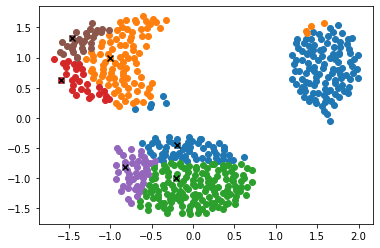

Iteration #2


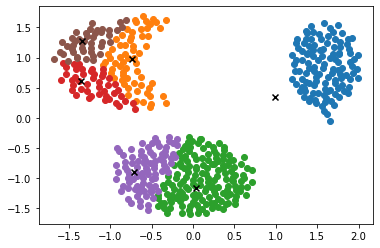

Iteration #3


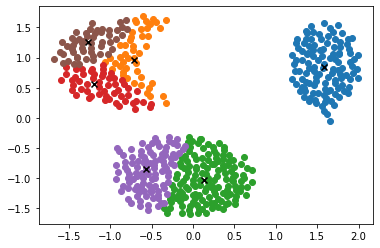

Iteration #4


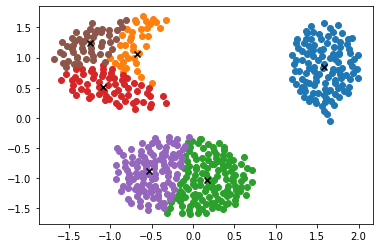

Iteration #5


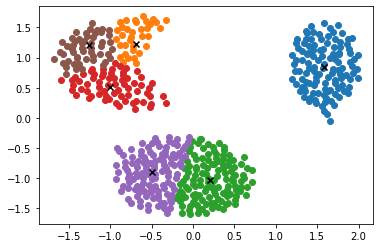

Iteration #6


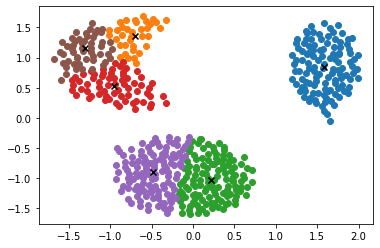

Iteration #7


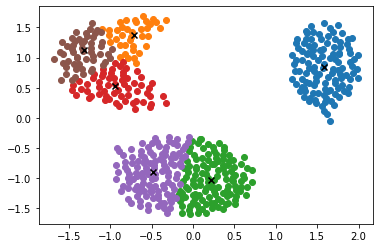

Iteration #8


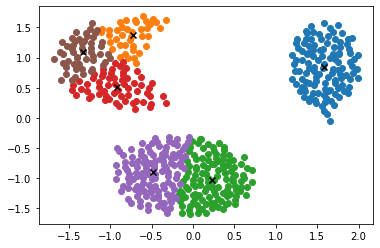

Iteration #9


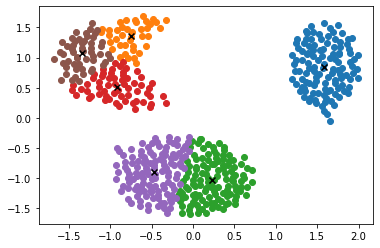

Iteration #10


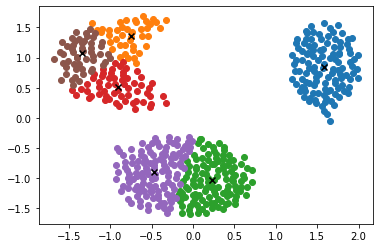

Iteration #11


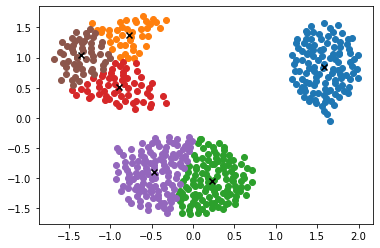

Iteration #12


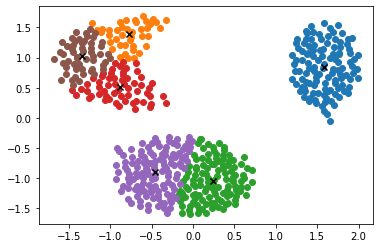

Iteration #13


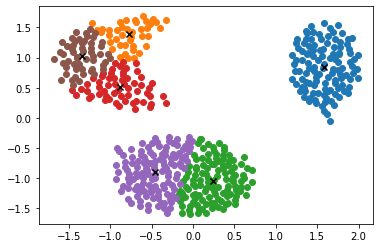

In [14]:
random.seed(666) #Initializy random library with a seed
dataset = get_dataset("cluster.dat") #Build the dataset
random.shuffle(dataset) #Randomize the dataset array
training_set, test_set = divide_dataset(dataset, 0.9, 0.1) #Partition the dataset
z_score_normalization(training_set, 2) #Apply the z-score normalization
centroids = kmeans(training_set, 6, 2) #Run the k-means algorithm, obtaining the centroids objects

# DBSCAN method

In [ ]:
#Class that represents a node for the DBSCAN method
class DBSCAN_node:
    def __init__(self, sample, label, cluster):
        self.sample = sample 
        self.label = label   # (undefined | noise | core | border)
        self.cluster = cluster # name of the cluster the node belongs to
        self.neighborhood = set() 
        
def DBSCAN_initialization(dataset):
    DBSCAN_dataset = []
    for sample in dataset:
        new_node = DBSCAN_node(sample, "undefined", -1)
        DBSCAN_dataset.append(new_node)
    
    return DBSCAN_dataset

In [83]:
def DBSCAN_plot_2D_clusters(clusters):
    for c in clusters:
        x = []
        y = []
        for point in clusters[c]:
            x.append(point.sample.features[0])
            y.append(point.sample.features[1])
        plt.scatter(x, y)    
    plt.show()

    
def DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point):
    neighbors = []
    for n in dataset:
        if dist_func(n.sample, point.sample, dim) <= eps:
            neighbors.append(n)
    
    return set(neighbors)


def DBSCAN_find_cluster(dataset, dist_func, dim, eps, minPoints, core, n_cluster):
    cluster = []
    to_explore = deque()
    
    cluster.append(core)
    to_explore.append(core)
    
    # explore neighborhoods to expand the current cluster
    while len(to_explore) > 0:
        q = to_explore.popleft()
        q.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, q)          
        
        # classify current point according to the size of its neighborhood
        if len(q.neighborhood) >= minPoints: # current point is core
            q.label = "core" 
            
            # mark each neighbor as part of the current cluster 
            for r in q.neighborhood:
                if r.label == "undefined" or r.label == "noise":
                    r.cluster = n_cluster
                    cluster.append(r)
                    
                    # classify current neighbor according to the size of its neighborhood
                    if len(DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, r)) >= minPoints:
                        r.label = "core"
                    else:
                        r.label = "border"
                    
                    # add neighbor to the queue (if it is not there yet), so its neioghborhood will be analyzed
                    if r not in to_explore:
                        to_explore.append(r)
                
        else: # current point is border  
            q.label = "border" 
    
    return cluster
    

# DBSCAN implementation
def DBSCAN(dataset, dist_func, dim, eps, minDensity):
    # obtain a dataset in the convenient format
    dataset = DBSCAN_initialization(dataset)
    
    # initialize auxiliary variables
    n_clusters = 0   # name of the clusters
    clusters = {}    # clusters obtained as the model
    clusters[0] = [] # list to gather all outliers as one cluster
    
    for point in dataset:
        if point.label == "undefined":
            point.neighborhood = DBSCAN_find_neighborhood(dataset, dist_func, dim, eps, point)
            
            # check neighborhood of the current point
            if len(point.neighborhood) >= minDensity: # neighborhood is large enough, current point is a core point
                point.label = "core"
                
                # start a new cluster
                n_clusters += 1 
                point.cluster = n_clusters
                clusters[n_clusters] = DBSCAN_find_cluster(dataset, dist_func, dim, eps, minDensity, point, n_clusters)
            
            else: # neighborhood not large enough, then classify current point as noise so that it may later be joined in some cluster
                point.label = "noise"
                point.cluster = 0
                    
    # create one cluster for all the outliers
    for point in dataset:
        if point.label == "noise":
            clusters[0].append(point)

    return dataset, clusters              
    

## Running DBSCAN for a two-dimensional dataset

In [154]:
# Get dataset
ds_filepath = "cluster.dat"
ds = get_dataset(ds_filepath)

# Pre-process and divide the dataset into training and test sets
random.seed(37154) 
random.shuffle(ds) 
training_set, test_set = divide_dataset(ds, 0.9, 0.1)
z_score_normalization(training_set, 2)
z_score_normalization(test_set, 2)

---------------------------------------------------------------------------------
Configuration: minDensity =  5 , eps =  1.0
There are 2 clusters and 0 outliers.


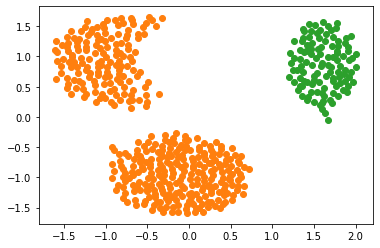

---------------------------------------------------------------------------------
Configuration: minDensity =  5 , eps =  0.8
There are 2 clusters and 0 outliers.


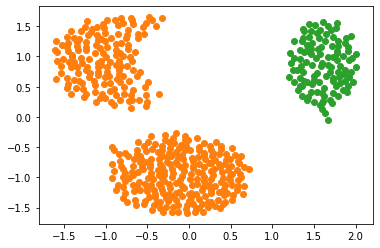

---------------------------------------------------------------------------------
Configuration: minDensity =  5 , eps =  0.6
There are 2 clusters and 0 outliers.


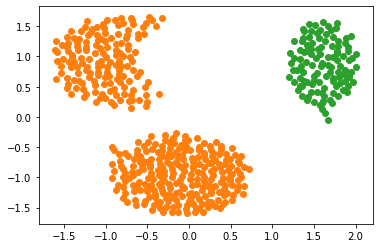

---------------------------------------------------------------------------------
Configuration: minDensity =  5 , eps =  0.4
There are 3 clusters and 0 outliers.


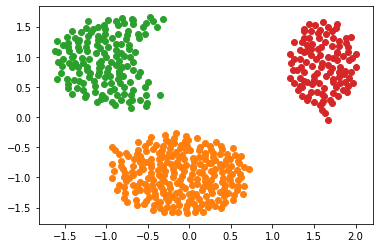

---------------------------------------------------------------------------------
Configuration: minDensity =  5 , eps =  0.2
There are 3 clusters and 0 outliers.


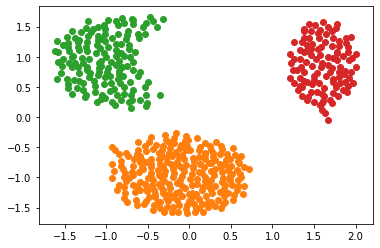

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  1.0
There are 2 clusters and 0 outliers.


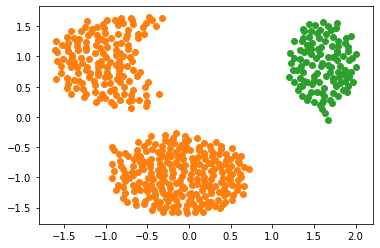

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.9
There are 2 clusters and 0 outliers.


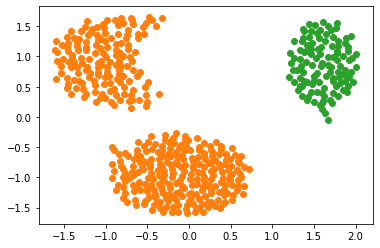

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.8
There are 2 clusters and 0 outliers.


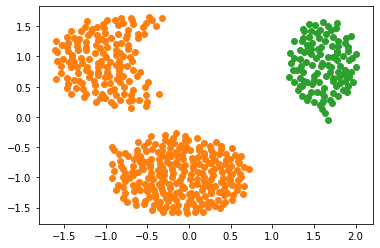

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.7
There are 2 clusters and 0 outliers.


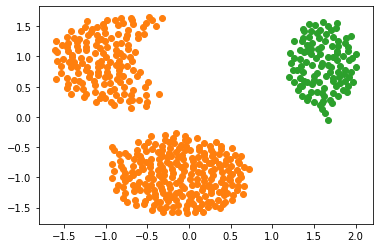

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.6
There are 2 clusters and 0 outliers.


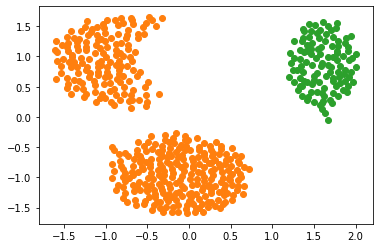

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.5
There are 3 clusters and 0 outliers.


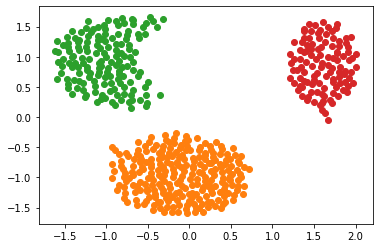

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.4
There are 3 clusters and 0 outliers.


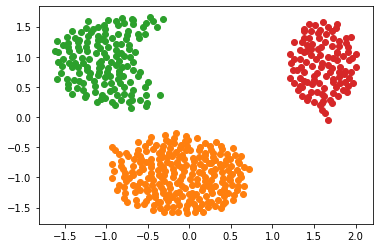

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.3
There are 3 clusters and 0 outliers.


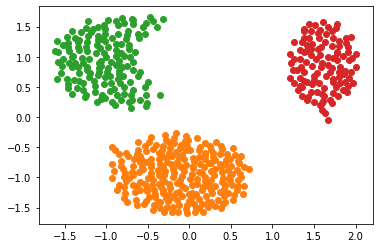

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.2
There are 3 clusters and 5 outliers.


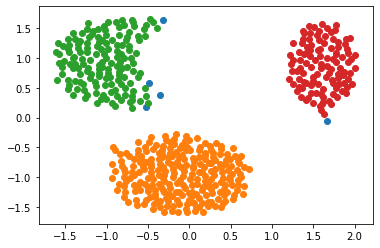

---------------------------------------------------------------------------------
Configuration: minDensity =  10 , eps =  0.1
There are 0 clusters and 515 outliers.


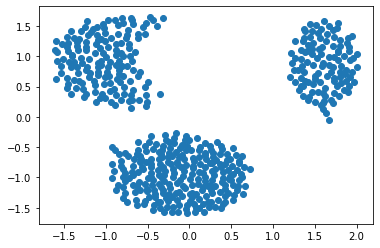

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  1.0
There are 2 clusters and 0 outliers.


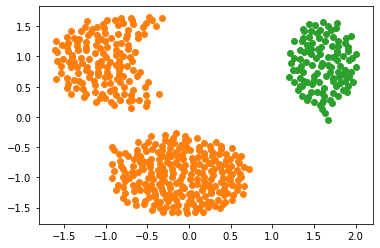

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.9333333333333333
There are 2 clusters and 0 outliers.


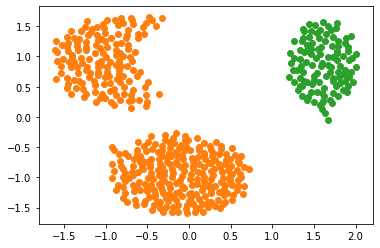

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.8666666666666667
There are 2 clusters and 0 outliers.


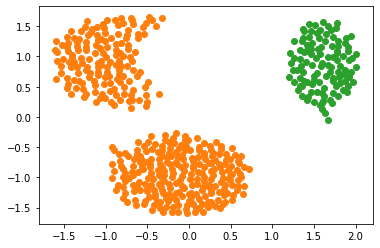

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.8
There are 2 clusters and 0 outliers.


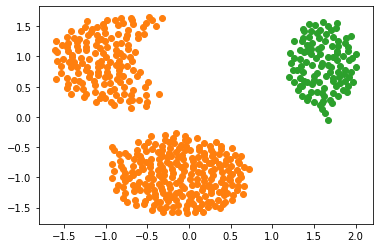

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.7333333333333333
There are 2 clusters and 0 outliers.


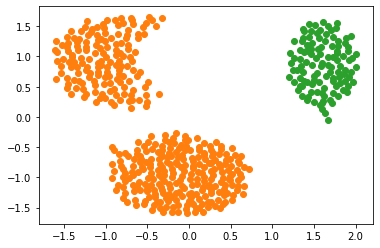

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.6666666666666666
There are 2 clusters and 0 outliers.


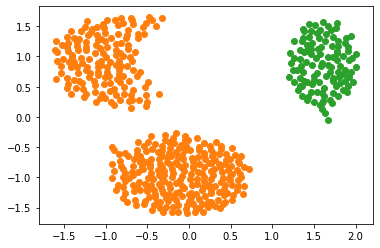

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.6
There are 2 clusters and 0 outliers.


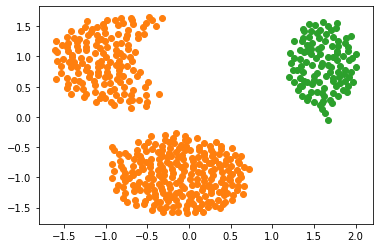

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.5333333333333333
There are 2 clusters and 0 outliers.


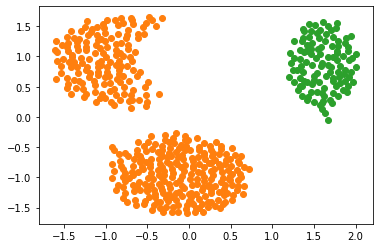

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.4666666666666667
There are 3 clusters and 0 outliers.


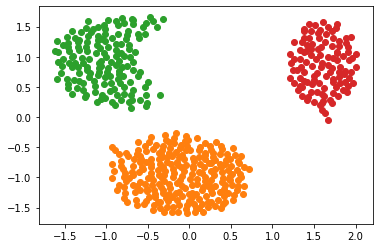

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.4
There are 3 clusters and 0 outliers.


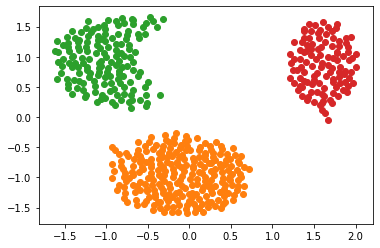

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.3333333333333333
There are 3 clusters and 0 outliers.


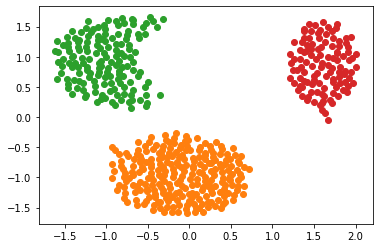

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.26666666666666666
There are 3 clusters and 2 outliers.


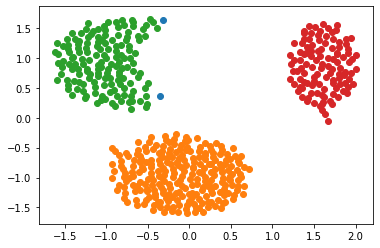

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.2
There are 4 clusters and 87 outliers.


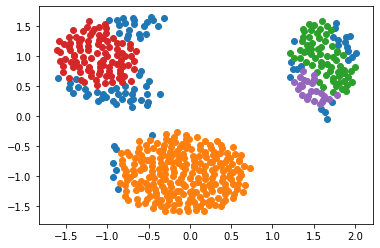

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.13333333333333333
There are 0 clusters and 515 outliers.


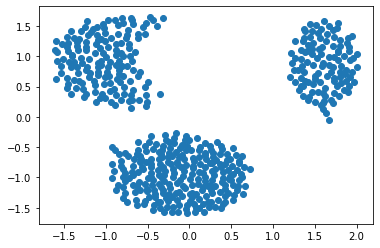

---------------------------------------------------------------------------------
Configuration: minDensity =  15 , eps =  0.06666666666666667
There are 0 clusters and 515 outliers.


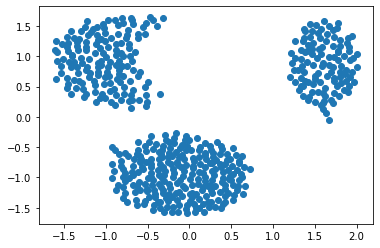

Conclusions: the value of the minimum density did not seem to affect the results in a high significant way, for this dataset. For minimum distance, however, if eps is too large, we could have some clusters containing several distant sets with high density, that is, some clusters that could have been separated in more different clusters. On the other hand, if eps is too small, we can end up with too many outliers; in the example, when eps<=0.3, all points were classified as outliers, which is not befitting with reality.


In [124]:
###############################
# Training step               #
###############################

# Run DBSCAN over the dataset using different values of minimum density and distance
for density in range(0,16,5):
    for eps in range(density, 0, -1):
        model = []
        clusters = {}
        model, clusters = DBSCAN(training_set, get_distance, 2, eps/density, density)    
        print("---------------------------------------------------------------------------------")
        print("\033[1mConfiguration:\033[0m minDensity = ", density, ", eps = ", eps/density)
        print("There are", len(clusters)-1, "clusters and", len(clusters[0]), "outliers.")
        DBSCAN_plot_2D_clusters(clusters)

print("\033[1mConclusions:\033[0m the value of the minimum density did not seem to affect the results in a high significant way, for this dataset. For minimum distance, however, if eps is too large, we could have some clusters containing several distant sets with high density, that is, some clusters that could have been separated in more different clusters. On the other hand, if eps is too small, we can end up with too many outliers; in the example, when eps<=0.3, all points were classified as outliers, which is not befitting with reality.")


Tunning the hiper-parameters:
As a rule of thumb, we have chosen the minimum density to be 2 times the dimension of the dataset. Although, by observation of the results plotted above, we noticed we could have chosen a larger value, such as 15, for instance.
As for the minimum distance, by the sole observation of the results plotted, we would have chosen the value 0.5.
However, as a more automated mechanism, we used the k-nearest neighbor graph to find a proper value of minimum distance. In the following, we present an elbow graph of the fartherest distance in the range of the k-nearest neighbors of each point.


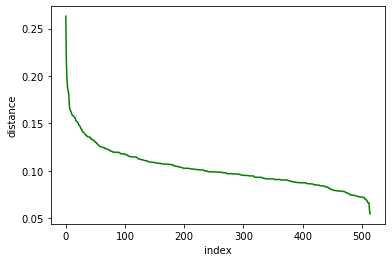

In [183]:
###############################
# Training step               #
###############################

print("\n\033[1mTunning the hiper-parameters:\033[0m")
print("As a rule of thumb, we have chosen the minimum density to be 2 times the dimension of the dataset. Although, by observation of the results plotted above, we noticed we could have chosen a larger value, such as 15, for instance.")
print("As for the minimum distance, by the sole observation of the results plotted, we would have chosen the value 0.5.")
print("However, as a more automated mechanism, we used the k-nearest neighbor graph to find a proper value of minimum distance. In the following, we present an elbow graph of the fartherest distance in the range of the k-nearest neighbors of each point.")

def get_nearest_distances(dataset, dist_func, dim, k, point):
    dist = []
    for q in dataset:
        dist.append(get_distance(q, point, dim))
    
    return sorted(dist)[:k]

# # Tunning the hiper-parameters
dim = len(training_set[0].features)
k = 2*dim # set k to be 2 times the number of features minus one

k_neighbors = {p : [] for p in training_set}
for p in training_set:
    k_neighbors[p] = get_nearest_distances(training_set, get_distance, dim, k, p) 

estimated_eps = [k_neighbors[p][k-1:] for p in training_set]
estimated_eps = sorted(estimated_eps, reverse=True)

# plot the elbow graph
x = [i for i in range(len(estimated_eps))]
y = estimated_eps
plt.xlabel("index")
plt.ylabel("distance")
plt.plot(x, y, 'g-')    
plt.show()


Based on the analysis of the elbow graph showed above, we chose the hiper-parameters to be:
minimum density =  4 and minimun distance =  0.16 

Now we will classify the test set. We use two approaches. In the fisrt one, we simply run the DBSCAN method over the test set using the configuration we found to be the most appropiate in the training step.
In the second approache, for each point of the test set, we find what its neighborhood would be in the training set, and then we count the number of times that each cluster occurs in this neighborhood. Finally, we assign the most frequent cluster in this neighborhood as the cluster of the point of the test set.
Observing the graphs ploted bellow, we can conclude that the second approach gave much better results than the first one.

Fisrt approach: run DBSCAN for the test set with the most convenient configuration obtained from the training step.


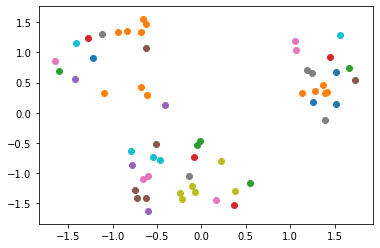


Second approach: assign to each point in the test set, the "most frequent cluster" in the neighborhood of the point when considered the training set.


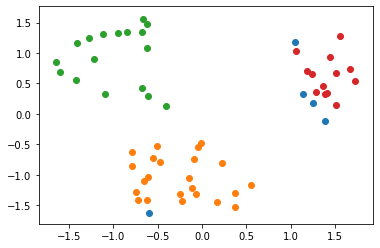

Conclusions:


In [182]:
###############################
# Validation step             #
###############################

# set hiper-parameters with the appropiate values
best_eps = 0.16
best_density = 4 #2*dim

# Validate the model obtained using proper values of the hiper-parameters
print("Based on the analysis of the elbow graph showed above, we chose the hiper-parameters to be:")
print("minimum density = ", best_density, "and minimun distance = ", best_eps, "\n")

# classify the test set according to the model obtained with the traininset
print("Now we will classify the test set. We use two approaches. In the fisrt one, we simply run the DBSCAN method over the test set using the configuration we found to be the most appropiate in the training step.")
print("In the second approache, for each point of the test set, we find what its neighborhood would be in the training set, and then we count the number of times that each cluster occurs in this neighborhood. Finally, we assign the most frequent cluster in this neighborhood as the cluster of the point of the test set.")
print("Observing the graphs ploted bellow, we can conclude that the second approach gave much better results than the first one.")

# first approach
print("\n\033[1mFisrt approach:\033[0m run DBSCAN for the test set with the most convenient configuration obtained from the training step.")
model = []
clusters_1 = {}
testset_labeled, clusters_1 = DBSCAN(test_set, get_distance, 2, best_eps, best_density / len(test_set))
DBSCAN_plot_2D_clusters(clusters_1)

# second approach
print("\n\033[1mSecond approach:\033[0m assign to each point in the test set, the \"most frequent cluster\" in the neighborhood of the point when considered the training set.")
# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,50)}
v_clusters = {key: [] for key in range(0,50)}

# get model generated by training the training set
model, clusters_2 = DBSCAN(training_set, get_distance, 2, best_eps, best_density)  

# classify each point of the test set one of the clusters of the model
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, 2, best_eps, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)
DBSCAN_plot_2D_clusters(v_clusters)


## Running DBSCAN for a n-dimensional dataset (n=10)

In [187]:
# Get dataset
ds_filepath = "trip_advisor.dat"
#ds_filepath = "wimbledon_men_2013.dat"
ds = get_dataset(ds_filepath)
dim = len(training_set[0].features) # get the number of features of the dataset

# Pre-process the dataset
random.seed(37154) 
random.shuffle(ds)
training_set, test_set = divide_dataset(ds, 0.9, 0.1) 
z_score_normalization(training_set, dim)
z_score_normalization(test_set, dim)

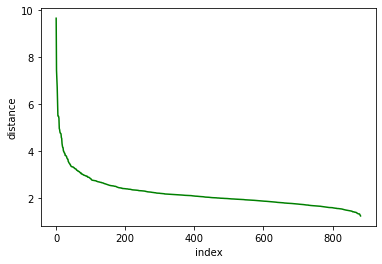

In [189]:
###############################
# Training step               #
###############################

# Tuning hiper-parameters
dim = len(training_set[0].features)
k = 2*dim # set k to be 2 times the number of features minus one

k_neighbors = {p : [] for p in training_set}
for p in training_set:
    k_neighbors[p] = get_nearest_distances(training_set, get_distance, dim, k, p) 

estimated_eps = [k_neighbors[p][k-1:] for p in training_set]
estimated_eps = sorted(estimated_eps, reverse=True)

# plot the elbow graph
x = [i for i in range(len(estimated_eps))]
y = estimated_eps
plt.xlabel("index")
plt.ylabel("distance")
plt.plot(x, y, 'g-')    
plt.show()


In [194]:
###############################
# Validation step             #
###############################

# set hiper-parameters with the appropiate values
best_eps = 3.5
best_density = 2*dim

# first approach
print("\nFisrt approach: run DBSCAN for the test set with the most convenient configuration obtained from the training step.")

clusters_1 = {}
testset_labeled, clusters_1 = DBSCAN(test_set, get_distance, dim, best_eps, best_density / len(test_set))
# DBSCAN_plot_2D_clusters(clusters)
print("test set, approach 1, number of clusters: ", len(clusters_1))

# second approach
print("\nSecond approach: assign to each point in the test set, the \"most frequent cluster\" in the neighborhood of the point when considered the training set.")
# obtain the model by rinning DBSCAN over the training set with the best configuration of parameters
model = []
clusters = {}
model, clusters = DBSCAN(training_set, get_distance, dim, best_eps, best_density)
print("training set, number of clusters: ", len(clusters))

# initialization of data set and auxiliary variables
v_set = DBSCAN_initialization(test_set)
neighbors_count = {key: 0 for key in range(0,len(test_set))}
v_clusters = {key: [] for key in range(0,len(test_set))}

# run through each point of the test set so as to classify them
for v_point in v_set:
    # get neighborhood of the current point as if it was placed in the model set
    v_neighborhood = DBSCAN_find_neighborhood(model, get_distance, dim, best_eps, v_point)
    
    # count the number of neighbors of each cluster
    for q in v_neighborhood:
        neighbors_count[q.cluster] += 1
    
    # set current point to the "most frequent" cluster in its "model neighborhood"
    v_point.cluster = max(neighbors_count, key=neighbors_count.get)
    
    # reset the counter of neighbors of each cluster
    neighbors_count = {key: 0 for key in neighbors_count}
    
# construct the dictionary with all clusters and plot the result
for p in v_set:
    v_clusters[p.cluster].append(p)
    
print("teset set, number of clusters: ", len(v_clusters))


Fisrt approach: run DBSCAN for the test set with the most convenient configuration obtained from the training step.
test set, approach 1, number of clusters:  2

Second approach: assign to each point in the test set, the "most frequent cluster" in the neighborhood of the point when considered the training set.
training set, number of clusters:  2
teset set, number of clusters:  98
